# Numerical Physics Project
# 1) Introduction
We are looking at the Travelling Salesman Problem, which can be mathematically formulated as : \
We have a set of $n$ cities, with $C_{i,j}$ being the distance between the city $i$ and the city $j$. The goal is to find the shortest path visiting every city exactly once and returning to the first city. We note $x_{i,t}$ a boolean variable, such that $x_{i,t}= 1$ if the $i$-th city is visited at timestep $t$, and  $x_{i,t}= 0$ otherwise.
Thus, our goal is to find $x \in \{0, 1\}^{n^2}$ which minimizes the cost function :
$$C_{\text{cost}}(x) = \sum_{0 \leq i,j<n} C_{i,j} \sum_t x_{i,t}x_{j, t+1}$$
Since we can only visit a given city once, and we can only be at one city at a given time, we also have the following constraints :
$$ \sum_{0\leq i <n } x_{i,t} = 1, \ \forall t \in [\![0, n-1]\!] $$
$$\sum_{0\leq t <n } x_{i,t} = 1, \ \forall i \in [\![0, n-1]\!] $$




To enforce the constraints, we will use a penalization term in the cost function. Essentially, we will use the cost function $C =  C_{\text{cost}} + M\cdot C_{\text{penalty}}$ where :
$$ C_{\text{penalty}} = \sum_{t}\left( 1 - \sum_{i} x_{i,t} \right)^2 + \sum_i \left(1 - \sum_t x_{i,t} \right)^2 $$
And $M$ is a constant large enough for the penalization to be efficient. Notice there are constant terms in $C_{\text{penalty}}$, which we will remove in the hamiltonian, and notice that the total cost function is quadratic in the variables $x_{i,t}$, meaning we can map it onto a Ising Hamiltonian using the correspondance $x_{i,j} \leftrightarrow \frac12(1-Z_{i,t})$ where $Z_{i,t}$ is the pauli operator $Z$ acting on the qubit $i,t$.
We note the cost Hamiltonian : 
$$ \hat{H}_C = \sum_{x \in  \{ 0, \ 1 \}^n } C(x) \ket{x}\bra{x}$$
which is diagonal in the computationnal basis, and in terms of operators is equivalent to replacing every $x_{i,t}$ in $C(x)$ by $\frac12(1-Z_{i,t})$. We start the code with the imports for using MyQLM, and the initialization of the problem : 

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from qat.lang.AQASM import Program
from qat.lang.AQASM import RX, X, H, Y, Z, PH, RZ

from qat.opt import CombinatorialProblem
from qat.vsolve.ansatz import AnsatzFactory
from qat.pylinalg import PyLinalg
from qat.qpus import get_default_qpu
from qat.clinalg import CLinalg
from qat.plugins import ScipyMinimizePlugin
from qat.plugins import SPSAMinimizePlugin
from qat.core import Result
from qat.core.qpu import QPUHandler
from qat.core import Result
from qat.core.wrappers.result import aggregate_data

# 2) Initializing the problem


We initialize the problem itself and a constraint constant :


In [22]:
nb_cities = 3  # number of cities
nbLayers = 10 #number of optimization layers for QAOA
C = [[0, 1000, 1], [1, 0, 1000], [1000, 1, 0]]  # Cost matrix of the travel between two cities
constraint_constant = 2*np.max(C) * nb_cities # Constraint constant, this one works well

We will now draw the graph to make it easier to directly spot the optimal paths. \
Since networkx used in conjunction with matplotlib does not allow correctly placed labels on curved edges, we will instead use the package graphviz for this. The installation being very tedious, we recommend you do not re-run the cell and leave it as is.

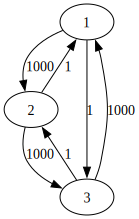

In [48]:

from graphviz import Digraph

G = Digraph()
# add nodes for each city
for i in range(nb_cities):
    G.node(str(i+1))
# add weighted edges
for (i,j), weight in np.ndenumerate(C):
    if weight != 0 :
        G.edge(str(i+1), str(j+1), str(weight))
#draw the graph
G

Then we use MyQLM's functions to construct the hamiltonian corresponding to the cost function :

In [23]:
# Create a combinatorial problem
problem = CombinatorialProblem("TSP", False)
# initialize the boolean variables
var_array = problem.new_vars(nb_cities**2)
# Now we create the cost function as a boolean function

# This part corresponds to the actual cost function
for i in range(nb_cities):
    for j in range(nb_cities):
        for t in range(nb_cities - 1):
            problem.add_clause(
                var_array[i + nb_cities * t]
                & var_array[j + nb_cities * ((t + 1) % nb_cities)],
                C[i][j],
            )

# This part corresponds to the penalisation added to the cost function
# Here we developed the squared sums, simplified it and removed the constant terms
for t in range(nb_cities):
    for i in range(nb_cities):
        problem.add_clause(var_array[i + nb_cities * t], (-2) * constraint_constant)
        for i2 in range(nb_cities):
            if i2 != i:
                problem.add_clause(
                    var_array[i + nb_cities * t] & var_array[i2 + nb_cities * t],
                    2*constraint_constant,
                )
        
        for t2 in range(nb_cities):
            if t2 != t:
                problem.add_clause(
                    var_array[i + nb_cities * t] & var_array[i + nb_cities * t2],
                    2*constraint_constant,
                )

Note that with this Hamiltonian, the lowest eigenvalue is $-35998$, we thus want to converge towards this value.

# 3) Using the Quantum Approximate Optimization Algorithm

Now that our cost function has been created, we use the qaoa_ansatz method to create our job, which is a runable parametrized QAOA circuit, corresponding to preparing the state : 
$$\ket{\Phi(\vec{\gamma},\vec{\beta} )}=  \prod_1^p e^{-i\beta_i \hat{H}_B} e^{-i\gamma_i \hat{H}_C} \ket{+}. $$
Where $\hat{H}_B = \sum_1^n X_i $ où $X_i$ and $\ket{+} = \left( \frac{\ket{0}+\ket{1}}{\sqrt{2}} \right) \otimes^n$

In [24]:
def run_qaoa(nb_layers):
    ansatz = problem.qaoa_ansatz(nb_layers)
    # initialize the optimizer
    # We chose the BFGS method because it is often regarded as the fastest optimization method for problems like this
    optimize = ScipyMinimizePlugin(
        method="BFGS", tol=1e-5, options={"maxiter": 10000}, x0 = [0.1]*(nb_layers*(nb_cities**2+1))
)  
    # We create a stack : the optimizer will feed jobs to the bottom part (the qpu) and optimize their parameters
    # We use the Broyden–Fletcher–Goldfarb–Shanno algorithm for the optimisation  as it usually works very well
    qpu = CLinalg()
    stack = (
        optimize | qpu
    )  
    result = stack.submit(ansatz)  # result
    print("energy : ", result.value)
    energy=result.value
    # we get the optimal parameters from the result and bind the variables of the circuit
    circuit = ansatz.circuit.bind_variables(
        result.parameter_map
    ) 
    job = circuit.to_job(
        nbshots=1000
    )  # a second job allowing us to know to what state the optimized parameters correspond 
    qpu = CLinalg()
    result = qpu.submit(job)  # result
    # for each state in the result we print its probability
    for sample in result:
        print("State %s amplitude %s" % (sample.state, sample.probability))
    # we then have to choose the most probable one
    return(energy)

In [25]:
nb_layers = []
energy_qaoa = []
for i in range(1, 16, 2):
    energy = run_qaoa(i)
    nb_layers.append(i)
    energy_qaoa.append(energy)

energy :  42597.14738421011
State |000000000> amplitude 0.006
State |000000011> amplitude 0.002
State |000000101> amplitude 0.002
State |000000110> amplitude 0.003
State |000000111> amplitude 0.001
State |000001001> amplitude 0.002
State |000001011> amplitude 0.001
State |000001110> amplitude 0.001
State |000001111> amplitude 0.001
State |000010000> amplitude 0.002
State |000010001> amplitude 0.001
State |000010010> amplitude 0.001
State |000010110> amplitude 0.002
State |000010111> amplitude 0.001
State |000011001> amplitude 0.001
State |000011011> amplitude 0.006
State |000011101> amplitude 0.01
State |000011110> amplitude 0.002
State |000011111> amplitude 0.002
State |000100000> amplitude 0.001
State |000100101> amplitude 0.002
State |000100110> amplitude 0.001
State |000100111> amplitude 0.001
State |000101000> amplitude 0.002
State |000101011> amplitude 0.001
State |000101101> amplitude 0.004
State |000101110> amplitude 0.001
State |000101111> amplitude 0.002
State |000110011> amp

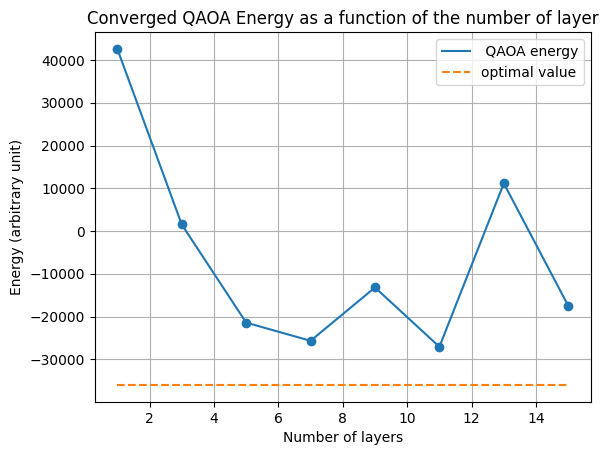

In [27]:
import matplotlib.pyplot as plt
plt.plot(range(1, 16, 2), energy_qaoa, label =' QAOA energy')
plt.scatter(range(1, 16, 2), energy_qaoa)
plt.plot([1, 15], [-35998, -35998], "--", label = "optimal value")
# Add labels and a title
plt.xlabel('Number of layers')
plt.ylabel('Energy (arbitrary unit)')
plt.title('Converged QAOA Energy as a function of the number of layer')
plt.legend(loc='best')
plt.grid()
# Show the plot
plt.show()

# 4) A Monte-Carlo Approach
Our idea was to compare the QAOA algorithm (whose convergence is proved if $p$ is large enough) to a much simpler algorithm. 
Instead of preparing the state $\ket{\Phi(\vec{\gamma},\vec{\beta} )}$ we prepare the state : $$\ket{\Phi(\vec{\theta})} = \prod_i e^{-i\theta_i X_i}\ket{0}$$
The idea is that modifying the parameters $\vec{\theta}$ allows us to reach any state of the basis (some of which are optimal). The problem is that any of these state is a vanishing point for the energy gradient (see the detailed report), so starting from a random $\vec{\theta}$ is likely to yield a non optimal state. However, we can expect the convergence to an optimal state to be more likely than to another state because the gradients are more likely to be directed towards them (since their energy is lower). Thus we designed a random alorithm which starts with a random $\vec{\theta}$ and performs the desired amount of times the optimization. We then choose the state whose frequency is the biggest. 


In [32]:
def mc_run():
    observable = problem.get_observable()
    prog = Program()
    reg = prog.qalloc(nb_cities**2)
    var =  [ prog.new_var(float,'theta'+str(i)) for i in range(nb_cities**2)]

    # if we want to add dephasing :
    #var2 = [ prog.new_var(float,'phi'+str(i)) for i in range(nb_cities**2)]

    # we just apply a RX(theta_i) gate on every qubit
    for i in range(nb_cities**2):
        prog.apply(RX(var[i]),reg[i])

        #dephasing : prog.apply(PH(var2[i]), reg[i])
    # From there on, everything is identical to the QAOA code
    circ = prog.to_circ()
    job = circ.to_job(observable=observable)
    # initialize the optimizer
    # Not specifying initial parameters makes those random
    optimize =ScipyMinimizePlugin(method="BFGS", tol=1e-5, options={"maxiter": 150}) 
    qpu = PyLinalg()
    # Once again create the stack
    stack =  optimize | qpu 
    # get the result
    result = stack.submit(job) 
    energy=result.value
    # We bind the variables using the optimized values
    circuit = job.circuit.bind_variables(result.parameter_map) 
    # A second job allowing us to assess the corresponding state using 10000 shots
    job = circuit.to_job(nbshots = 10000) 
    qpu = PyLinalg()
    result = qpu.submit(job) # result
    for sample in result:
        return( str(sample.state), sample.probability, energy)

def monte_carlo(n_runs):
    best_state = ""
    best_energy = 0
    for _ in range(n_runs):
        state, _, energy = mc_run()
        if energy < best_energy : 
            best_energy = energy
            best_state = state
    return(best_energy, best_state)
    

In [28]:
energy_mc = []
run_number = []
for i in range(1,16):
    run_number.append(i)
    _, _, energy2 = mc_run()
    energy_mc.append(energy2)

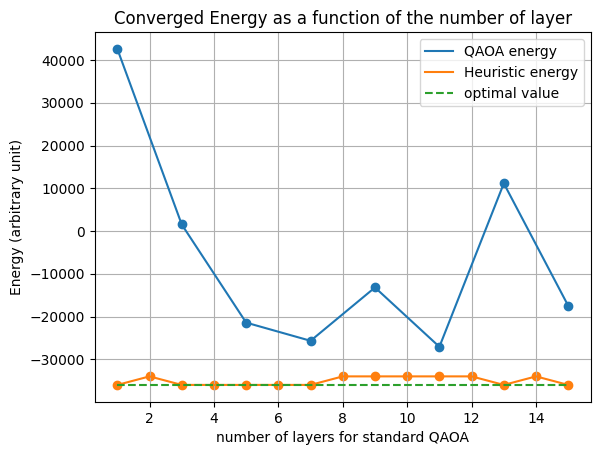

In [29]:
plt.plot(range(1,16,2), energy_qaoa, label='QAOA energy')
plt.plot(range(1,16), energy_mc, label='Heuristic energy')
plt.scatter(range(1,16,2), energy_qaoa)
plt.scatter(range(1,16), energy_mc)
plt.plot([1, 15], [-35998, -35998], "--", label = "optimal value")
plt.xlabel('number of layers for standard QAOA')
plt.ylabel('Energy (arbitrary unit)')
plt.title('Converged Energy as a function of the number of layer')
plt.legend(loc='best')
plt.grid()
# Show the plot
plt.show()

To see how the distribution of states is for a big number of repetitions, we ran the heuristic for $200$ steps. Since this takes a lot of time, we kept the result, which you can see below.

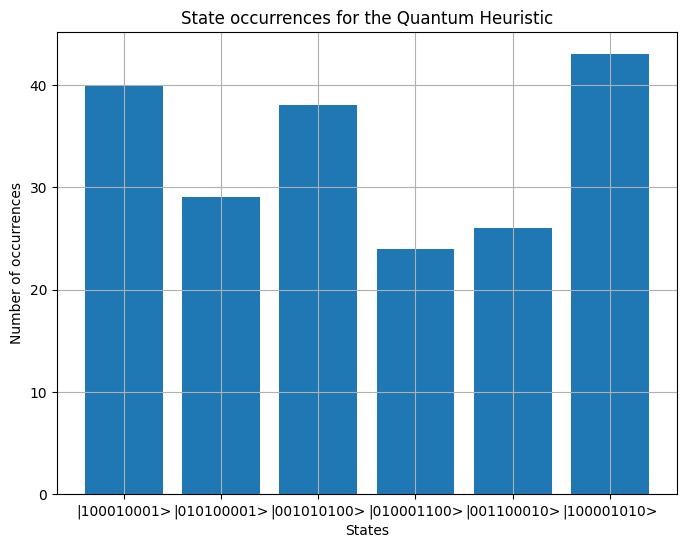

In [30]:
#for runtime = 200
states = []
plt.figure(figsize=(8, 6))
heights = []
for x, height in {'|100010001>': 40, '|010100001>': 29, '|001010100>': 38, '|010001100>': 24, '|001100010>': 26, '|100001010>': 43}.items() :
    states.append(x)
    heights.append(height)
plt.bar(states, heights)
plt.grid()
plt.xlabel('States')
plt.ylabel('Number of occurrences')
plt.title('State occurrences for the Quantum Heuristic')
plt.show()

We can see that $\ket{100001010}$ is the most frequent one, and it is an optimal solution.

In [33]:
monte_carlo(20)

(-35997.99999999997, '|010100001>')

We indeed get an optimal solution, even with $20$ runs here

$$\textbf{4) Mixing the two approaches}$$

The preceding approach has the upside of needing very shallow circuits, but the results are not as convincing as wished.
Our idea was therefore to combine the two approaches, by essentially using the QAOA but adding degrees of freedom in the mixer hamiltonian to allow our algorithm to explore more efficiently the Hilbert space.
More formally, we start from the QAOA but replace $\vec{\beta}$ which is of dimension $p$ (remember that $p$ is the number of layers) with an array $(\beta_{i,j})$ of size $p \cdot c$, and instead of preparing  $$\  \prod_1^p e^{-i\beta_i \hat{H}_0} e^{-i\gamma_i \hat{H}_C} \ket{+},$$ we prepare the state : $$ \ket{\Phi(\vec{\gamma},\beta )}=  \prod_1^p e^{-i\sum_0^n \beta_{i,j} X_j} e^{-i\gamma_i \hat{H}_C} \ket{+}. $$
We introduced more freedom in the optimisation, meaning the energy yielded in the end by this algorithm should be better than the one yielded by the QAOA.  

In [35]:
# We need to use undocumented functions which are contained in qat.fermion in order to create our custom mixer
from qat.fermion.hamiltonians import SpinHamiltonian
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.core import Term
H_cost = problem.get_observable()
terms = H_cost.terms
# initialize a hamiltonian
H_cost = SpinHamiltonian(nb_cities**2, terms, 1)
def custom_qaoa_ansatz(p):
    prog = Program()
    qbits = prog.qalloc(nb_cities**2)
    # We need to create the mixer hamiltonian ourselves
    def create_mixer_hamiltonian(layer_nb):
        terms = []
        vars = [prog.new_var(float, f'beta{layer_nb},{j}') for j in range(nb_cities**2)]
        # Add the terms beta_i,j*X_j
        for i in range(nb_cities**2): 
            terms.append(Term(vars[i],"X", [i]))
        H_mixer = SpinHamiltonian(nb_cities**2, terms, 1)
        return(H_mixer)
    gamma = [ prog.new_var(float,f'gamma{i}') for i in range(p)   ]   
    for i in range(nb_cities**2):
        prog.apply(X, qbits[i])
    for i in range(0,p):
        H_mixer = create_mixer_hamiltonian(i)
        H2 =(gamma[i])*H_cost
        # This function basically applies our hamiltonian to the registry using trotterisation
        H1_rout = make_trotterisation_routine(H_mixer, 1,1)
        H2_rout = make_trotterisation_routine(H2, 1,1)
        prog.apply(H2_rout, qbits)
        prog.apply(H1_rout, qbits)
    circuit = prog.to_circ()
    job = circuit.to_job(observable=H_cost)
    return(job)

In [37]:
nb_layers = 3
ansatz = custom_qaoa_ansatz(nb_layers)
optimize = ScipyMinimizePlugin(
    method="BFGS", tol=1e-5, options={"maxiter": 1000}, x0 = [0.1]*(nb_layers*(nb_cities**2+1))
)  
# We create a stack : the optimizer will feed jobs to the bottom part (the qpu) and optimize their parameters
# We use the Broyden–Fletcher–Goldfarb–Shanno algorithm for the optimisation  as it usually works very well
qpu = CLinalg()
stack = (
    optimize | qpu
)  
result = stack.submit(ansatz)  # result
print("Energy : ", result.value)
# we get the optimal parameters from the result and bind the variables of the circuit
circuit = ansatz.circuit.bind_variables(
    result.parameter_map
) 
job = circuit.to_job(
    nbshots=10000
)  # a second job allowing us to know to what state the optimized parameters correspond 
qpu = CLinalg()
result = qpu.submit(job)  # result
# for each state in the result we print its probability
for sample in result:
    print("State %s amplitude %s" % (sample.state, sample.probability))
# we then have to choose the most probable one

Energy :  -89500.49998194566
State |001100010> amplitude 1.0
